# The Impact of COVID-19 on Gaming
By Tim Clark

With the COVID-19 pandemic causing many people to be stuck at home with very little ability to interact in person with family and friends, how have people been spending their newfound alone time? In this tutorial, we will be looking at how the sales of video game hardware and software, along with comparisons to active computer gaming player data have been affected by the quarantine. Along the way, we will learn about the Data Science Pipeline and how it can help us understand phenomenon in our data and in life through data collection and management, exploratory data analysis, and hypothesis testing.

## Background

Throughout the pandemic, I have been seeing articles like [Covid-19: Nintendo profits triple as games boom continues](https://www.bbc.com/news/business-54813841) and [The Nintendo Switch can't be stopped](https://www.theverge.com/2021/5/6/22422451/nintendo-annual-earnings-switch-84-59-million) were news sites are claiming that the pandemic has caused a dramatic increase in console and game sales with everyone being stuck at home with nothing to do. Similar claims have been made by outlets like [Polygon](https://www.polygon.com/2020/3/23/21191397/steam-highest-active-player-record-coronavirus-covid-19) and [The Washington Post](https://www.washingtonpost.com/video-games/2020/05/12/video-game-industry-coronavirus/) about [Steam](https://store.steampowered.com/), the most popular digital video game marketplace for PC gaming. Steam keeps track of daily users who are both active in the Steam Client, and users playing games. While I do believe that console sales continue to rise and active players have increased on Steam *(I myself have been spending more time gaming)*, I am skeptical of just how much the pandemic has affected the video game sales and activity, so I decided to look into it myself using financial data directly from the source and a historical look at Steam player activity.

## Setup Libraries
The first thing we need to do is import the libraries we will use to gather, store, manipulate, and plot the data.


In [365]:
from sklearn.linear_model import LinearRegression
from IPython.display import display
from bs4 import BeautifulSoup
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import sklearn

## Collecting Data
The next step is actually collecting the data we will be using. Since we are looking at sales data I found only two of the three major console manufacuturers publish thier sales numbers for the public: Nintendo and Sony. We will be comparing this to 

Nintendo hosts all of their financial data about the company's profits, hardware sales, and software sales for each console they create on thier website: https://www.nintendo.co.jp/ir/en/finance/index.html. The dataset we will be using from Nintendo can be found in an excel spreadsheet here: https://www.nintendo.co.jp/ir/en/finance/historical_data/index.html under 'Consolidated Sales Transition by Region'. Since this is a spreadsheet, we can use Pandas directly to parse the section of the spreadsheet we need for the Nintendo Switch data into a dataframe after we download the spreadsheet and save it first.

In [367]:
# Get the sales spreadsheet for nintendo hardware and software
switch_url = 'https://www.nintendo.co.jp/ir/finance/historical_data/xls/consolidated_sales_e2103.xlsx'
res = requests.get(switch_url)
# Save the retrieved spreadsheet to disk
with open('switch.xlsx', 'wb') as f:
    f.write(res.content)
# Specific sheet for switch data
sheet = 'Nintendo DS and after'
# Rows for the switch data
rows = range(0,74)
# Parse switch sales data within the excel sheet
table = pd.read_excel('switch.xlsx', sheet, header=4, skiprows=rows, usecols='E,R:W')
# Rename table columns
table.columns = ['Region', '2017', '2018', '2019', '2020', '2021', 'LTD']

Sony hosts data of their PlayStation 4 and 5 sales on thier Sony Interactive Entertainment website here: https://www.sie.com/en/corporate/data.html. Unfortunately this data doesn't have nearly the amount of history as Nintendo, but that won't be a problem as we will just be looking at the PlayStation 4 and 5 data as it is the most revelant to the impact of COVID-19. Since this data doesn't come in a nice spreadsheet like the Nintendo data, we will have to scrape the webpage to extract the tables that we want for the sales data. We will use BeautifulSoup to find the table elements in the html page and parse them into an array so that each table can be converted to a dataframe using pandas.read_html.

In [369]:
page = requests.get('https://www.sie.com/en/corporate/data.html')
# Parse the html page using BeautifulSoup
soup = BeautifulSoup(page.text, 'html.parser')
# Find all tables in the BeautifulSoup data
soup_table = soup.find_all('table')
# Extract ps4 hardware data and convert to pandas
ps4_hardware = pd.read_html(str(soup_table[1]))[0]
# Extract ps4 software data and convert to pandas
ps4_software = pd.read_html(str(soup_table[4]))[0]

The last bit of data we're going to collect is a history of concurrent users on Steam and in-game. This data is comes from a website called [SteamDB](https://steamdb.info/app/753/graphs/) who have logged the realtime data that Steam gives through their API to display how many people are online on the Steam Game client, and how many are in a game. This data will gives us more information on how the computer side of gaming has been affected by the pandemic. I have downloaded the csv file from the link above and we will load that in using pandas and grab the last few years of data to analyze. 

In [371]:
steam = pd.read_csv('chart.csv').dropna().reset_index(drop=True)

display(steam)

,DateTime,Users,In-Game
0,2017-11-13 00:00:00,14054902.0,3948383.0
1,2017-11-14 00:00:00,13983638.0,5007635.0
2,2017-11-15 00:00:00,14048277.0,5063418.0
3,2017-11-16 00:00:00,13762149.0,5042709.0
4,2017-11-17 00:00:00,15128594.0,5738598.0
...,...,...,...
1268,2021-05-11 00:00:00,24338738.0,5839850.0
1269,2021-05-12 00:00:00,24159130.0,5903423.0
1270,2021-05-13 00:00:00,24335218.0,6198772.0
1271,2021-05-14 00:00:00,24710062.0,6376830.0


## Tidying up Data
After we have collected the data, we need to tweak it a bit in order to make it clean and easy to use for analysis. Since we are talking about video games, and namely consoles right now, we need to look at both the hardware (the physical consoles that play games) and the software (or the games themselves). This is an important distinction because there may be a significant difference in the hardware and software sales as people who already have a console just by more games to play or more people who don't have a console buy hardware to play games. This will help give us more avenues to search for spikes or dips in sales that could be due to COVID-19.

The first thing we will to is split the Nintendo Switch data into two diffrent tables, the hardware and the software. Since there are two versions currently for sale, Nintendo has created an entry in their data for each version broken down by region. For our purposes, however, we don't care about this hardware distinction as all sales are equal for looking at the number of people buying playing games so we will be combining this data using the groupby() and sum() method to merge the same region entries and add the sales numbers together.

In [373]:
# Separate and merge data for Switch and Switch Lite sales
sw_hardware = table[:10].groupby('Region', sort=False).sum().reset_index()
sw_hardware

,Region,2017,2018,2019,2020,2021,LTD
0,Japan,60.0,378.0,385.0,721.0,841.0,2385.0
1,The Americas,120.0,594.0,688.0,1044.0,1524.0,3968.0
2,Europe,76.0,379.0,455.0,668.0,928.0,2505.0
3,Other,18.0,154.0,169.0,290.0,441.0,1072.0
4,Total,274.0,1505.0,1695.0,2722.0,3734.0,9929.0


After we have the hardware data, the software data is just the last few rows after the hardware data so we can copy these and reset the indices

In [375]:
# Separate Switch software data
sw_software = table[10:15].reset_index(drop=True)
sw_software

,Region,2017,2018,2019,2020,2021,LTD
0,Japan,89.0,1226.0,2148.0,3256.2364,4502.0,11222.0
1,The Americas,286.0,2752.0,5394.0,7427.6634,10242.0,26100.0
2,Europe,142.0,1917.0,3516.0,5016.8035,6624.0,17215.0
3,Other,29.0,456.0,797.0,1171.3154,1720.0,4174.0
4,Total,546.0,6351.0,11855.0,16872.0187,23088.0,58712.0


Now that we have the correct data in two separate tables, we want to make sure that the data can be compared to the data from Sony. Nintendo has noted that all these numbers are in rounded units of ten thousand, while Sony's data is published in the rounded millions of units. We can convert the Nintendo data to millions of units by dividing it by 100. Then, we will manipulate the axes so that each row is a year and the columns include region data so that it will be easier to graph later on and it matches the data from Sony.

In [377]:
# Divide data to convert to millions
sw_hardware.iloc[:,1:] = sw_hardware.iloc[:,1:].divide(100)
# Transpose rows and columns removing the column names
sw_hardware = sw_hardware.T.reset_index()[1:6]
# Add proper column names
sw_hardware.columns = ['Year', 'Japan', 'The Americas', 'Europe', 'Other', 'Total']
# For each non-year column convert string numbers to floats
for col in sw_hardware.columns:
    if col != 'Year':
        sw_hardware[col] = sw_hardware[col].astype(float)
    else:
        sw_hardware[col] = sw_hardware[col].astype(int)
# Divide data to convert to millions
sw_software.iloc[:,1:] = sw_software.iloc[:,1:].divide(100)
# Transpose rows and columns removing the column names
sw_software = sw_software.T.reset_index()[1:6]
# Add proper column names
sw_software.columns = ['Year', 'Japan', 'The Americas', 'Europe', 'Other', 'Total']
# For each non-year column convert string numbers to floats
for col in sw_software.columns:
    if col != 'Year':
        sw_software[col] = sw_software[col].astype(float)
    else:
        sw_software[col] = sw_software[col].astype(int)

display(sw_hardware)
display(sw_software)

ValueError: invalid literal for int() with base 10: 'Japan'

Now that we hav the Nintendo data organized, we will work through the Sony PlayStation data. The biggest problem with Sony's data is that thier fiscal years are different than Nintendo's. Instead of running on calendar years, companies tend to have their own fiscal years which for Sony and Nintendo start in April and end in March of the following year. While it is good that both companies' fiscal years line up on the same month, meaning we can compare out data yearly with more precision, Sony labels their fiscal year based on the calendar year it starts in while Nintendo lables it by the year it ends. For this reason, we will be matching Sony's fiscal year with Nintendo's just by increasing the year by one for Sony so that the data lines up correctly.

In [ ]:
# Set the column names
ps4_hardware.columns = ['Year', 'Q1', 'Q2', 'Q3', 'Q4', 'FY']
# Remove the letters from the year
ps4_hardware['Year'] = [int(y[2:])+1 for y in ps4_hardware['Year']]
# Replace missing data with zeros
ps4_hardware = ps4_hardware.replace('-',0)
# For each non-year column convert string numbers to floats
for col in ps4_hardware.columns:
    if col != 'Year':
        ps4_hardware[col] = ps4_hardware[col].astype(float)

# Set the column names
ps4_software.columns = ['Year', 'Q1', 'Q2', 'Q3', 'Q4', 'FY']
# Remove the letters from the year
ps4_software['Year'] = [int(y[2:])+1 for y in ps4_software['Year']]
# Replace missing data with zeros
ps4_software = ps4_software.replace('-',0)
# For each non-year column convert string numbers to floats
for col in ps4_software.columns:
    if col != 'Year':
        ps4_software[col] = ps4_software[col].astype(float)
        
display(ps4_hardware)
display(ps4_software)

Before we finish up organizing the data, there is one more problem, as you can see in the software table, the las two quarters of the 2021 fiscal year have no sales entries. This would be a case of missing data, however it is not because Sony has not reported this data, it is because this specific table has not been updated since October 2020 according to the website and they have instead combined the software sales data of the PlayStation 4 with the PlayStation 5 sales data. Since the data is there, but there is no way to extract just the single console's sales, we will instead combine the data to include both PlayStation 4 and 5 sales data. 

Originally I was not going to include the data for the PlayStation 5 as there are other factors in that are currently affecting sales of this hardware, including the [global silicon chip shortage that is hitting many industries](https://www.cnbc.com/2021/02/10/whats-causing-the-chip-shortage-affecting-ps5-cars-and-more.html), [scalpers buying up stock to resell at exorbitant prices](https://www.washingtonpost.com/technology/2020/12/16/ps5-buying-bot/), and overall lower production that is common in the first fiscal year of a console's lifetime. These bots and scalpers would potentially inflate sales numbers as more stock is being sold and less people actually playing the consoles, however with the shortages reducing production and sales overall, it would appear to balance out. According to Michael Driscoll, a Data Engineer who has analyzed the sale of PS5 consoles on reseller markets like eBay and OfferUp, an estimated [10 to 15% of consoles](https://arstechnica.com/gaming/2021/02/scalpers-arent-the-main-reason-you-cant-find-a-new-console/) that have been sold in the US from these reseller sites, suggesting that the affect of the scalpers is not nothing, but doesn't have the greatest affect on the accuracy of Sony's salesdata.

In order to make sure we have no NaN data, we will first gather the PlayStation 5 hardware data from another table on the website and add it to the PlayStation 4 data.

In [349]:
# Temporarily extract the ps5 hardware data
temp = pd.read_html(str(soup_table[2]))[0].replace('-', 0)
# Make it look like the ps4 data
temp.columns = ['Year', 'Q1', 'Q2', 'Q3', 'Q4', 'FY']
temp['Year'] = [int(y[2:])+1 for y in temp['Year']]
for col in temp.columns:
    if col != 'Year':
        temp[col] = temp[col].astype(float)
# Combine the ps4 and ps5 hardware data into a new dataframe, summing sales
ps_hardware = pd.concat([ps4_hardware, temp], ignore_index=True).groupby('Year').agg({'Q1':'sum', 'Q2':'sum', 'Q3':'sum', 'Q4':'sum', 'FY':'sum'}).reset_index()

# Temporarily extract the ps5 software data
temp = pd.read_html(str(soup_table[5]))[0].replace('-', 0)
# Make it look like the ps4 data
temp.columns = ['Year', 'Q1', 'Q2', 'Q3', 'Q4', 'FY']
temp['Year'] = [int(y[2:])+1 for y in temp['Year']]
for col in temp.columns:
    if col != 'Year':
        temp[col] = temp[col].astype(float)
# Combine the ps4 and ps5 software data into a new dataframe, summing sales
ps_software = pd.concat([ps4_software, temp], ignore_index=True).groupby('Year').agg({'Q1':'sum', 'Q2':'sum', 'Q3':'sum', 'Q4':'sum', 'FY':'sum'}).reset_index()

display(ps_hardware)
display(ps_software)

,Year,Q1,Q2,Q3,Q4,FY
0,2014,0.0,0.0,4.5,3.1,7.6
1,2015,2.8,3.4,6.4,2.3,14.8
2,2016,2.9,4.0,8.4,2.4,17.6
3,2017,3.5,3.9,9.7,2.9,20.0
4,2018,3.3,4.2,9.0,2.5,19.0
5,2019,3.2,3.9,8.1,2.6,17.8
6,2020,3.2,2.8,6.0,1.4,13.5
7,2021,1.9,1.5,5.9,4.3,13.5


,Year,Q1,Q2,Q3,Q4,FY
0,2017,39.9,54.0,85.5,54.9,234.2
1,2018,45.9,76.1,92.8,59.4,274.2
2,2019,47.7,82.3,95.6,62.3,292.7
3,2020,50.5,71.6,88.7,65.3,276.1
4,2021,91.4,81.8,104.2,61.4,165.6


For the steam data, we can't to the same manipulations to organize the data similarly to the Nintendo and Sony data since we have datapoints for each individual day. Instead, we will just add a new column that just gives the year for each row so that it will be easier to plot in the next part.

In [350]:
# Convert the DateTime to actual DateTime objects
steam['DateTime'] = pd.to_datetime(steam['DateTime'], infer_datetime_format=True)
# Extract the year for each row into its own column
steam['Year'] = [str(date.year) for date in steam['DateTime']]
# Rename In-Game column to avoid error when doing ols regression later
steam.rename(columns={'In-Game':'In_Game'}, inplace=True)

display(steam)

,DateTime,Users,In_Game,Year
0,2017-11-13,14054902.0,3948383.0,2017
1,2017-11-14,13983638.0,5007635.0,2017
2,2017-11-15,14048277.0,5063418.0,2017
3,2017-11-16,13762149.0,5042709.0,2017
4,2017-11-17,15128594.0,5738598.0,2017
...,...,...,...,...
1268,2021-05-11,24338738.0,5839850.0,2021
1269,2021-05-12,24159130.0,5903423.0,2021
1270,2021-05-13,24335218.0,6198772.0,2021
1271,2021-05-14,24710062.0,6376830.0,2021


## Exploratory Data 
Now that our data is cleaned up, we can begin the Exploratory Data Analysis phase of our Data Science pipleline. Here, we will be looking through each of our datasets, looking for any potential patterns that we can use to make a hypothesis about what the data says for our topic. For our console sales, we want to look at the data and see if there is anything that would indicate a spike in sales around the pandemic. 

First, we will look at the hardware sales for both the Nintendo Switch and Sony PlayStation:

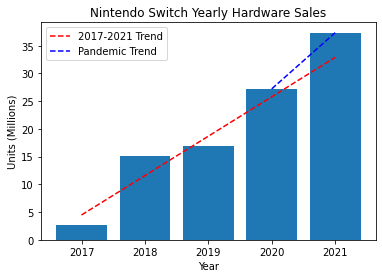

In [351]:
# Set x and y values
x = sw_hardware['Year'][:5]
y = sw_hardware['Total'][:5]
# Plot hardware on bar graph
plt.bar(x, y)
# Create Trend line for Switch lifetime
z = np.polyfit(x[:3], y[:3], 1)
p = np.poly1d(z)
plt.plot(x, p(x),"r--", label='2017-2021 Trend')
# Create Trend line for during pandemic
z = np.polyfit(x[3:], y[3:], 1)
p = np.poly1d(z)
plt.plot(x[3:], p(x[3:]),"b--", label='Pandemic Trend')

plt.title('Nintendo Switch Yearly Hardware Sales')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Units (Millions)')
plt.show()

As you can see, the Nintendo Switch has been on a rise in sales since launch, however, the increase in sales during the pandemic has an overall higher than that of the two years prior. This would suggest that there could be a correlation between the increased sales and more people playing games due to COVID-19.

Now let's look at the PlayStation sales:

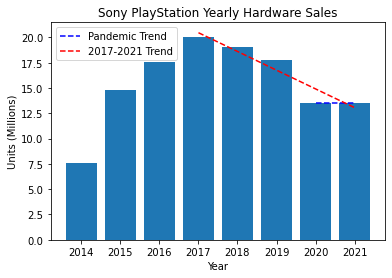

In [352]:
x = ps_hardware['Year']
y = ps_hardware['FY']
plt.bar(x, y)
z = np.polyfit(x[6:], y[6:], 1)
p = np.poly1d(z)
plt.plot(x[6:], p(x[6:]),"b--", label='Pandemic Trend')
z = np.polyfit(x[3:], y[3:], 1)
p = np.poly1d(z)
plt.plot(x[3:], p(x[3:]),"r--", label='2017-2021 Trend')
plt.title('Sony PlayStation Yearly Hardware Sales')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Units (Millions)')
plt.show()

Here we see a different story than Nintendo. During the same time period, there is a negative trend in sales with a stagnation in the pandemic time period. Since most of this data is from PS4 sales, and the PS5 has just released with supply issues, it would make sense that sales would decrease at the end of the life for the PS4 and production on the PS5 is not able to compensate yet, but this does not show any correlation between the pandemic and sales.

Now lets look at the sales data for the games themselves as many people already had consoles before the pandemic, as seen from the hardware sales data,and might buy new games.

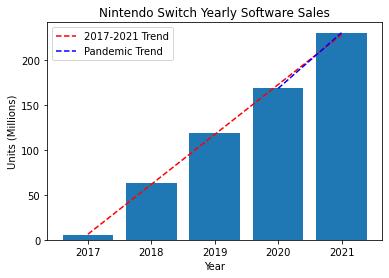

In [353]:
# Set x and y values
x = sw_software['Year']
y = sw_software['Total']
# Plot hardware on bar graph
plt.bar(x, y)
# Create Trend line for Switch lifetime
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x),"r--", label='2017-2021 Trend')
# Create Trend line for during pandemic
z = np.polyfit(x[3:], y[3:], 1)
p = np.poly1d(z)
plt.plot(x[3:], p(x[3:]),"b--", label='Pandemic Trend')

plt.title('Nintendo Switch Yearly Software Sales')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Units (Millions)')
plt.show()

As we can see from the data, Software sales for the Nintendo Switch increase similarly to the hardware, although in a more linear fashion. While this may give an indication of a linear correlation between the year and the sales of games, it does not give any correlation that would imply that the pandemic affected the sales.

How about the PlayStation games?

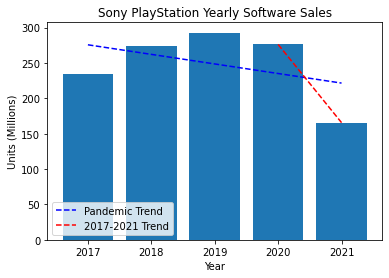

In [354]:
x = ps_software['Year']
y = ps_software['FY']
# Plot software on bar graph
plt.bar(x, y)
# Create Trend line for during pandemic
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x),"b--", label='Pandemic Trend')
# Create Trend line for overall time
z = np.polyfit(x[3:], y[3:], 1)
p = np.poly1d(z)
plt.plot(x[3:], p(x[3:]),"r--", label='2017-2021 Trend')

plt.title('Sony PlayStation Yearly Software Sales')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Units (Millions)')
plt.show()

Again we see a similar trend to the harware sales, where it looks like the pandemic has negatively affected the software sales similarly to the hardware sales.

With these sales charts in mind, there doesn't appear to be any correlation between sales and the pandemic. While there could be a correlation with the PlayStation sales being negatively affected by the pandemic, there are enough compounding factors that could also explain and contribute to the low sales that the confidence in the numbers is to low to explore.

The last thing we will explore is the Steam activity data to see if there is a significance in the data within the pandemic time period. First we will look at both active Steam users and Steam users in-game together:

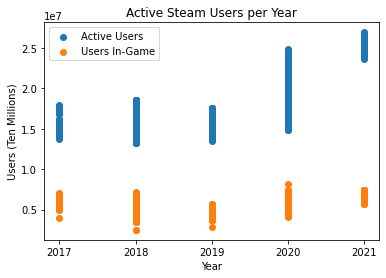

In [355]:
# Plot active user data
plt.scatter(steam['Year'], steam['Users'], label='Active Users')
# Plot in-game user data
plt.scatter(steam['Year'], steam['In_Game'], label='Users In-Game')

plt.title('Active Steam Users per Year')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Users (Ten Millions)')
plt.show()

Above, we can see that the chart is pretty interesting. While there are definitely more active users than users that are actually playing games, meaning many more players are just logged into Steam and not necessarily playing games, both group show a similar behavior that we can look at more closely below:

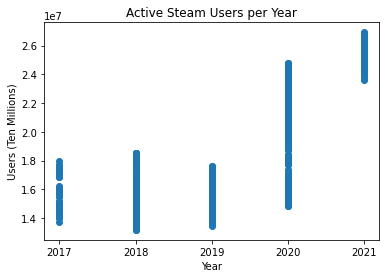

In [356]:
plt.scatter(steam['Year'], steam['Users'])

plt.title('Active Steam Users per Year')
plt.xlabel('Year')
plt.ylabel('Users (Ten Millions)')
plt.show()

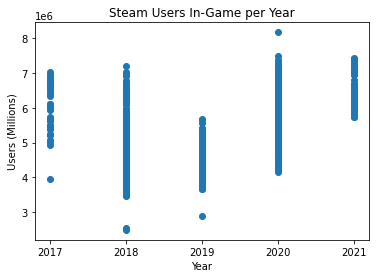

In [357]:
plt.scatter(steam['Year'], steam['In_Game'])

plt.title('Steam Users In-Game per Year')
plt.xlabel('Year')
plt.ylabel('Users (Millions)')
plt.show()

These two graphs show a very similar behavior of a lower average amount of people active and playing games on Steam in 2017-2019, and then a significant increase in users in 2020 and 2021. We can convert these scatterplots into violin plots to get a better look at how the data is distributed:

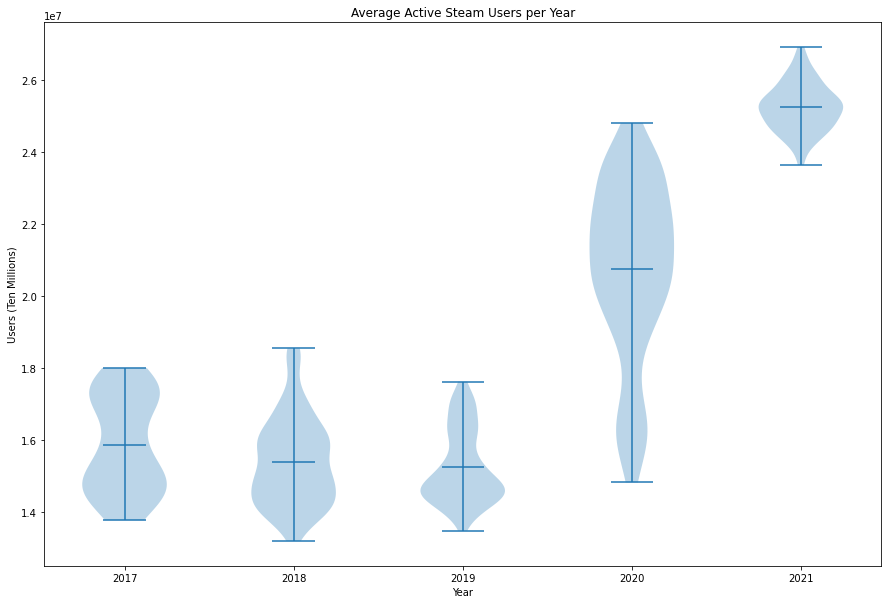

In [358]:
# Resize figure for clarity
plt.figure(figsize=(15,10))
# Set the year column to integers so it will play nicer with the violin plot
steam['Year'] = [int(date.year) for date in steam['DateTime']]
# Organize user data in 2d array by year so that a violin can be made per-year
users = [steam.loc[steam['Year'] == y]['Users'] for y in steam['Year'].unique()]
# Plot data on violin plot
plt.violinplot(users, steam['Year'].unique(), showmeans=True)

plt.title('Average Active Steam Users per Year')
plt.xlabel('Year')
plt.ylabel('Users (Ten Millions)')
plt.show()

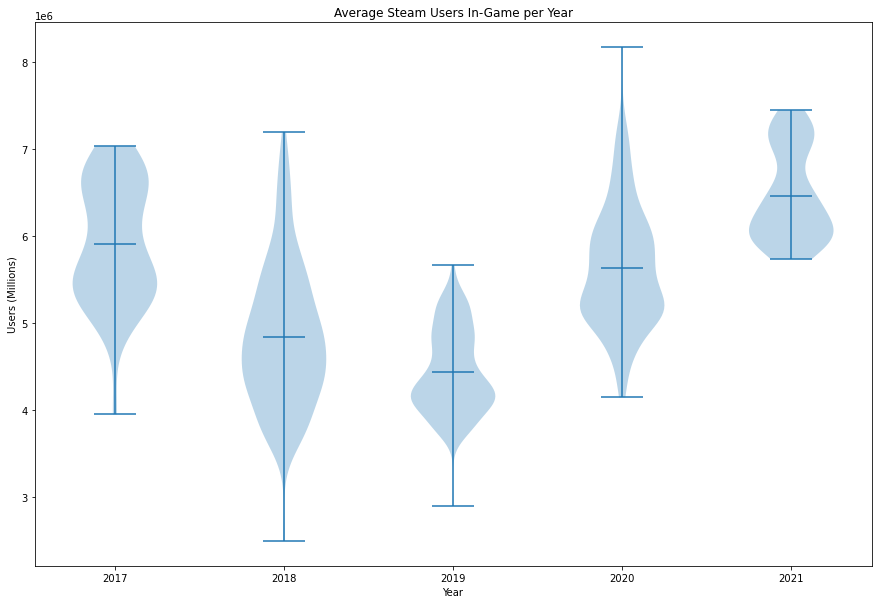

In [359]:
# Resize figure for clarity
plt.figure(figsize=(15,10))
# Organize user data in 2d array by year so that a violin can be made per-year
users = [steam.loc[steam['Year'] == y]['In_Game'] for y in steam['Year'].unique()]
# Plot data on violin plot
plt.violinplot(users, steam['Year'].unique(), showmeans=True)

plt.title('Average Steam Users In-Game per Year')
plt.xlabel('Year')
plt.ylabel('Users (Millions)')
plt.show()

These violin plots tell us that there is a decreasing average trend from 2017-2019 in both active and in-game users with a concentration in slightly below average users each year. Then in 2020, the average spikes up to well above the average for 2017 in active users and about the same amount of in-game users as 2017. In 2021, we see that the average increases even more with even more concentration towards the average in both in-game and active users. This would suggest that there is a correlation between the years of the pandemic and active users on Steam, playing video games.

Since our sales data from Nintendo and Sony do not show a significant pattern that would appear to be correlated to the years of the pandemic, I think it would be best to conclude our analysis of that data here and continue to explore the data from Steam. This is an important part of the Data Science Pipleine in which we have to go back to the previous steps of collecting and analyzing data from another source and modify the direction of our analysis. It is common to need to go back to previous steps because you need more data to continue your analysis or modify your hypothesis. For this tutorial we will be changing directions and looking at the affect COVID-19 has on gaming activity amongst pc gamers instead of sales of console games.

Now, let's begin to formalize our analysis into a hypothesis that we can test.

## Hypothesis Testing and Maching Learning

The next step in the Data Science Pipeline is testing a hypothesis and/or using machine learning to either confirm or refute our findings. Hypothesis Testing is a statistics method of verifying a data model and/or correlations within the data by testing multiple hypothesis that could explain phenomenon in the data.

Since we are looking for a correlation between the time period in which the pandemic takes place and the number of active Steam users and in-game Steam users, we will be looking for a linear correlation between the year and the users.

To start we will contruct our hypotheses and give ourselves a significance level which will be a threshold for how large our P-values can be and still reject the null hypothesis:

___Significance $\alpha$___ = 0.05

___H<sub>0</sub>___ = There is no linear correlation between the year and active Steam users

___H<sub>1</sub>___ = There is a linear correlation between the year and active Steam users

We will start our testing by looking at a linear regression model on both the active users and in-game users over time. We can use the sklearn LinearRegression function to create a regression model and give it our year and user data to fit the model to. Then, using the fitted model we will generate a prediction for the data that will predict what the trend should be for the data based on the model.



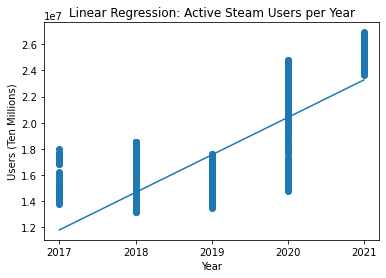

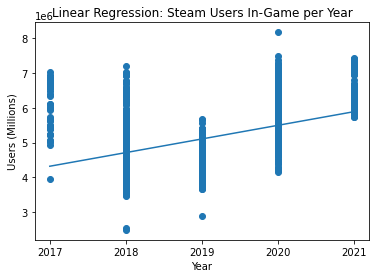

In [360]:
# Organize year data into 1d array for linear regression
x = np.array(steam['Year'])[:,None]
# Organize user data into 1d array for linear regression
y = np.array(steam['Users'])[:,None]
# Plot user data
plt.scatter(x, y)
# Create a linear regression model fit to the year and users
regr = LinearRegression().fit(x, y)
# Predict the user values based on the model
y = regr.predict(x)
# Plot linear regression
plt.plot(steam['Year'], y)
# A fix for the plot wanting to add .5 marks which make no sense in years
plt.xticks(np.arange(2017, 2022))

plt.title('Linear Regression: Active Steam Users per Year')
plt.xlabel('Year')
plt.ylabel('Users (Ten Millions)')
plt.show()

# Organize in-game data into 1d array for linear regression
y = np.array(steam['In_Game'])[:,None]
# Plot in-game data
plt.scatter(x, y)
# Create a linear regression model fit to the year and in-game users
regr = LinearRegression().fit(x, y)
# Predict the user values based on the model
y = regr.predict(x)
# Plot linear regression
plt.plot(steam['Year'], y)
# A fix for the plot wanting to add .5 marks which make no sense in years
plt.xticks(np.arange(2017, 2022))

plt.title('Linear Regression: Steam Users In-Game per Year')
plt.xlabel('Year')
plt.ylabel('Users (Millions)')
plt.show()

In both graphs above, we can see that despite the general decline in users in the first three years, the regression model trends upwards with a positive coefficient, implying that there is a significance to the increase in active users in 2020 and 2021. It also suggests that there is a positive linear correlation between the year and the number of active users.

To verify this further, lets look at another interpretation of a linear regression using the least squares regression from the statsmodels library. 

First the OLS (Ordinary Least Squares) model for the active user data:

In [361]:
# Create least squares regression model to verify P and F-Values
model = smf.ols('Users ~ Year', steam).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Users   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     2221.
Date:                Mon, 17 May 2021   Prob (F-statistic):          3.45e-281
Time:                        06:42:00   Log-Likelihood:                -20455.
No. Observations:                1273   AIC:                         4.091e+04
Df Residuals:                    1271   BIC:                         4.092e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.766e+09   1.23e+08    -46.977      0.0

Here we can see that our P-values (which can be found under P>|t|) are less than our significance, which means we have enough significance in our model to reject the null hypothesis for active users as the regression model fits the data better than the model without the year as an independent variable. Meaning there is a correlation between the year and active users, suggesting that the spike in active users is tied to increases in people at home having more time to play games.

Finally, lets test the in-game user data in the same fashion:

In [362]:
# Create least squares regression model to verify P and F-Values
model = smf.ols('In_Game ~ Year', steam).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                In_Game   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     316.7
Date:                Mon, 17 May 2021   Prob (F-statistic):           1.99e-63
Time:                        06:42:00   Log-Likelihood:                -19163.
No. Observations:                1273   AIC:                         3.833e+04
Df Residuals:                    1271   BIC:                         3.834e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.865e+08   4.45e+07    -17.679      0.0

Again we see that our P-values are less than our significance so we can reject the null hypothesis for this set of data too.

## Conclusion

From our regression analysis, it is safe to assume that there is a correlation between the spike in user activity and the years this spike took place in. Using this correlation and the fact that the spike in users was during the same years in which people were sheltered at home, it is a safe assumption that these events are correlated as well. If we look back at the trend of the user activity in our exploratory analysis, the important factor is that the user activity was on a decline before 2020, with a sharp increase in 2020, around the same time that nation-wide lockdowns began to take affect, leading everyone to be stuck at home with little to do. Had there been a stagnation in the activity or an increase in activity leading to 2020, it would be less likely that the increase from 2020-2021 would be due to the pandemic. However, with the results of the regression model and initial analysis of the data trend, I am confident enough to state that there is a correlation between the COVID-19 pandemic leading to an increase of people staying at home and playing video games.

### About the sales data...

In the beginning of this tutorial, I started with looking at sales data for the Nintendo Switch and Sony PlayStation 4 & 5, but changed gears and decided to look at Steam activity. I decided to keep this in the tutorial as I believe it to be an important step in the process that should be highlighted more. A lot of times in projects you will go down a path and hit a dead end as the data is not giving you any conclusive results. I had initially heard that the pandemic was leading to a spike in people buying consoles to play games and pass the time from articles like [this one from CNBC](https://www.cnbc.com/2020/06/02/nintendo-switch-animal-crossing-and-coronavirus-led-to-record-sales.html). As we could see from the analysis above, while there was an increase in sales of both consoles and games, it was in trend with the increase in sales of previous years, making it difficult to have conclusive evidence that articles like these were telling the whole story. I did not make the choice to forgo the hypothesis testing on the sales data until I looked at the charts generated in the process of this tutorial, thus it was an import step in the tutorial and in my exploration of the topic.

### Error

In any Data Science application, it is important to take note of where errors can occur in your data and analysis to more accurately represent the reality of the data. While we were able to show a correlation between the spike in active users and the year that spike took place, and I believe there is enough correlation within the data to come to a conclusion, this is not a foolproof analysis of the situation. This initial analysis could be further explored with a comparison to the number of people who were at home during this time period using data on the difference of foot-traffic data from common destinations before and during the pandemic. An analysis could be done with a similar linear regression model using the Steam user and the foot-traffic datasets to find a correlation that would confirm or refute the conclusions of this tutorial.

Unfortunately I wasn't able to find a reputable dataset source with global data to match the global data from Steam, so I will leave it up to you to use the information you learned in this tutorial to continue this statistical research using data from this tutorial and COVID-19 data.

Thank you for reading this analysis on game activity data during COVID-19 and I hope you enjoyed learning about the Data Science Pipline and the effect of COVID-19 on gaming.

In [363]:
from collections import Counter
from string import punctuation

r = requests.get('https://codenobacon4u.github.io/cmsc320-final-pandemic-gaming/')
soup = BeautifulSoup(r.content)
# We get the words within paragrphs
text_p = (''.join(s.findAll(text=True))for s in soup.findAll('p'))
c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
print(len(sorted(c_p.elements())))

2085
